# Contextual bandit

What is the optimal policy for a one-dimensional contextual bandit environment with a bimodal reward-state distribution?

## Define environment

# Hyperparameters: constant

- Standard deviation of normal distributions $\sigma$
- Relative weightings of the two distributions in the mix $p$

### Hyperparameters: variable

- Midpoint between the means of the normal distributions
- Separation between the means of the normal distributions

### Parameters

- Environmental state (feature / context / cue) $s$ (see [Hyperparameters: variable](#hyperparameters-variable))
- Action choice $a$ 
- Probability of a reward $P(r|s,a)$
- Actual reward in a given instance $R(s,a)$

### Implications of single-timestep episodes

- There's no model of the environment because there are no state transitions (and episode initialisations are random)
- Could be considered a *nonstationary* problem because the expected rewards are changing each episode (even though the hyperdistribution from which those expected rewards are sampled is fixed)

In [1]:
# Import libraries
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import norm
import jax.random
from jax.nn import softmax, sigmoid

from jax import grad, value_and_grad, vmap
from flax import linen as nn
import optax

In [15]:
class BimodalBandit:
    def __init__(self, midpoint, distance, key, sigma=1, p=0.5):
        self.midpoint = midpoint
        self.distance = distance
        self.p = p
        self.sigma = sigma
        self.mu1 = midpoint - distance / 2
        self.mu2 = midpoint + distance / 2
        self.key = key

    def define_reward_probability(self, action):
        reward_probability = self.p * norm.pdf(action, self.mu1, self.sigma) + \
                    (1 - self.p) * norm.pdf(action, self.mu2, self.sigma)
        return reward_probability

    def simulate_reward(self, action):
        self.key, subkey = jax.random.split(self.key)
        reward_probability = self.define_reward_probability(action)
        reward = jax.random.bernoulli(subkey, p=reward_probability).astype(int) 
        # JAX returns booleans, so we convert to int
        return reward

# Set seeds
master_key = jax.random.PRNGKey(0)
master_key, bandit_key = jax.random.split(master_key)

# Set state parameters and bandit environment generator
midpoint = 0
distance = 4
bandit = BimodalBandit(midpoint=midpoint, distance=distance, key=bandit_key) 

# Generate action space and reward probabilities for plotting
action_space = jnp.linspace(-10, 10, 4000)
reward_probabilites = jnp.array([bandit.define_reward_probability(action) for action in action_space])
simulated_rewards = jnp.array([bandit.simulate_reward(action) for action in action_space])
# TODO: vectorize the simulation of rewards


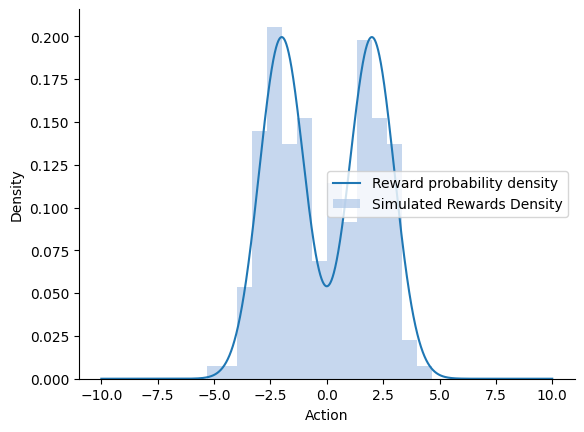

In [16]:
def plot_bimodal_bandit(action_space, reward_probabilites, simulated_rewards):
    fig, ax1 = plt.subplots()
    colors = ['#1f77b4', '#aec7e8']  # Blue color palette

    ax1.set_xlabel('Action')
    ax1.set_ylabel('Density')

    # Plot the PDF
    ax1.plot(action_space, reward_probabilites, color=colors[0], label='Reward probability density')

    # Plot the histogram of simulated rewards with density=True
    ax1.hist(action_space, 
             weights=simulated_rewards, 
             bins=30, alpha=0.7, 
             color=colors[1], 
             density=True, 
             label='Simulated Rewards Density')

    # Add a legend
    ax1.legend()

    # Create L-shaped box
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

# Call the plot_bimodal_bandit function
plot_bimodal_bandit(action_space, reward_probabilites, simulated_rewards)


### Key steps
1. **Sample** trajectories
2. **Fit** a model (e.g. environment / value function)
3. **Improve** the policy

In [33]:
# SUPERVISERD LEARNING - NEURAL NETWORK

# Neural Network Definition
class SimpleNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(32)(x)   
        x = nn.relu(x)
        # x = nn.Dropout(rate=0.2, deterministic=False)(x)  # Increased dropout
        x = nn.Dense(16)(x)   # Additional layer
        x = nn.relu(x)
        # x = nn.Dropout(rate=0.2, deterministic=False)(x)  # Another dropout layer
        x = nn.Dense(1)(x)
        return x
# TODO: turn off dropout for inference versus training mode

# Initialize the model and optimizer
rng = jax.random.PRNGKey(0)
model = SimpleNN()
params = model.init(rng, jnp.ones((1,)))['params']
optimizer = optax.adam(0.01)
opt_state = optimizer.init(params)

# Define the loss function

def binary_cross_entropy_with_logits(logits, labels):
    """Computes binary cross entropy given logits and true labels."""
    logits = logits.squeeze()  # Ensure logits are of shape (N,)
    labels = labels.squeeze()  # Ensure labels are of shape (N,)
    return -jnp.mean(labels * jnp.log(sigmoid(logits)) + (1 - labels) * jnp.log(1 - sigmoid(logits)))

def loss_fn(params, actions, rewards):
    actions_reshaped = actions.reshape(-1, 1)  # Reshaping actions to match input shape
    logits = model.apply({'params': params}, actions_reshaped)
    loss = binary_cross_entropy_with_logits(logits, rewards)
    return loss

# Training loop
for epoch in range(1000):  # Number of epochs
    loss, grads = value_and_grad(loss_fn)(params, action_space, simulated_rewards)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")


Epoch 0, Loss: 1.1414647102355957
Epoch 100, Loss: 0.15335239470005035
Epoch 200, Loss: 0.14990222454071045
Epoch 300, Loss: 0.14753912389278412
Epoch 400, Loss: 0.14634160697460175
Epoch 500, Loss: 0.14538010954856873
Epoch 600, Loss: 0.14475712180137634
Epoch 700, Loss: 0.1440684199333191
Epoch 800, Loss: 0.14367038011550903
Epoch 900, Loss: 0.14340484142303467


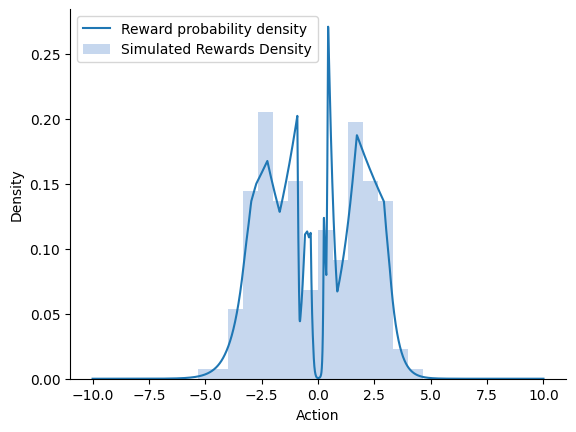

In [34]:
actions_reshaped = action_space.reshape(-1, 1)
pred_rewards = model.apply({'params': params}, actions_reshaped)
probabilities = sigmoid(pred_rewards)

plot_bimodal_bandit(action_space, probabilities, simulated_rewards)

In [21]:
# VALUE-BASED METHOD

# (3) IMPROVE
# Function to select the best action
def select_action(bandit, params, action_space): 
    # TODO: state as input, not bandit
    values = jax.vmap(lambda a: -value_function(a, params))(action_space)
    optimal_action_index = jnp.argmax(values)
    # TODO: 
    #   - action stochasticity
    #   - exploration
    #   - randomisation to select between actions with tied values 
    return action_space[optimal_action_index]

# (2) FIT
# Function to update the function approximator parameters
def update_params(params, action, reward, learning_rate=0.01):
    # Simple update rule for illustration
    theta1, theta2, theta3 = params
    theta1_updated = theta1 + learning_rate * reward
    theta2_updated = theta2 + learning_rate * (action - theta2) * reward
    theta3_updated = theta3 + learning_rate * reward
    return jnp.array([theta1_updated, theta2_updated, theta3_updated])
    # Could also just re-fit to entire dataset to avoid the need for an update rule
    # - is learning rate necessary?

# Value function (simple quadratic function for ilustration)
def value_function(action, params):
    theta1, theta2, theta3 = params
    return -(theta1 * (action - theta2)**2 + theta3)

# Initialize parameters
params = jnp.array([1.0, 0.0, 0.0])  # Initial parameters
action_space = jnp.linspace(-10, 10, 400)  # Discretized action space

# (1) SAMPLE
# Initialize bandit environment
master_key = jax.random.PRNGKey(0)
_, bandit_key = jax.random.split(master_key)
bandit = BimodalBandit(midpoint=0, distance=4, key=bandit_key, sigma=1, p=0.5)

# Iterative learning process
for iteration in range(100):
    # (3) IMPROVE + (1) SAMPLE
    action = select_action(bandit, params, action_space) 
    # (1) SAMPLE
    reward = bandit.simulate_reward(action) 
    # (2) FIT
    params = update_params(params, action, reward) 
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Action: {action}, Reward: {reward}")

# Final chosen action
final_action = select_action(bandit, params, action_space)
print(f"Final chosen action: {final_action}")


Iteration 0, Action: -10.0, Reward: 0
Iteration 10, Action: -10.0, Reward: 0
Iteration 20, Action: -10.0, Reward: 0
Iteration 30, Action: -10.0, Reward: 0
Iteration 40, Action: -10.0, Reward: 0
Iteration 50, Action: -10.0, Reward: 0
Iteration 60, Action: -10.0, Reward: 0
Iteration 70, Action: -10.0, Reward: 0
Iteration 80, Action: -10.0, Reward: 0
Iteration 90, Action: -10.0, Reward: 0
Final chosen action: -10.0


In [7]:
# POLICY-BASED METHOD

# (2) FIT + (3) IMPROVE
# TODO:
#   - separate policy model / loss from update function (?)
#   - simplify / demystify the NN model

# Define the policy model
# The policy samples actions according to a Gaussian distribution with parameters mean and sd

class PolicyModel(nn.Module):
    @nn.compact
    def __call__(self):
        # Outputs mean and log(std) of the action distribution
        mean = nn.Dense(1, kernel_init=nn.initializers.zeros)(jnp.array([1.0]))
        log_std = nn.Dense(1, kernel_init=nn.initializers.zeros)(jnp.array([1.0]))
        return mean, log_std

# Define the policy loss and gradient

def policy_loss(mean, log_std, action, reward):
    std = jnp.exp(log_std)
    prob_density = jax.scipy.stats.norm.pdf(action, mean, std)
    log_prob = jnp.log(prob_density)
    return -log_prob * reward  # Negative because we want to maximize this value

@jax.jit
def update(params, optimizer, optimizer_state, action, reward):
    mean, log_std = PolicyModel().apply({'params': params})
    loss, grads = jax.value_and_grad(policy_loss)(mean, log_std, action, reward)
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, optimizer_state, loss

# Initialize and train the policy model

# Initialize model and optimizer
rng_key = jax.random.PRNGKey(0)
model = PolicyModel()
params = model.init(rng_key)['params']
optimizer = optax.adam(learning_rate=0.01)
optimizer_state = optimizer.init(params)

# TODO: doesn't run
# Training loop
for i in range(100):
    mean, log_std = model.apply({'params': params})
    # (1) SAMPLE
    rng_key, subkey = jax.random.split(rng_key)
    action = jax.random.normal(subkey) * jnp.exp(log_std) + mean  # Sample action 
    reward = bandit.simulate_reward(action.item())  # Assume bandit can process numpy float 
    # (2) FIT + (3) IMPROVE
    params, optimizer_state, loss = update(params, optimizer, optimizer_state, action, reward)

    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss}, Action: {action}, Reward: {reward}")


In [ ]:
# # Value-based action selection
# def greedy_policy(state, action_space, action_values):
#     action_values = jnp.array(action_values)
#     # Select the action with the highest value
#     chosen_action = jnp.argmax(action_space)
#     return chosen_action

# # Policy-based action selection
# # just store the current action probabilities as a vector
# # later, use gradient descent to improve them?
# def explicit_policy(state, action_space):
#     action_proba
#     return chosen_action

# # Modify the policy to include exploration
# epilon_greedy(action_probabilities, epsilon=0.1, exploration_method="random", exploration_range=[-10, 10]):
#     if exploration_method == "random":
#         # select action according to uniform distribution in exploration_range
#     else:
#         # select action according to action_probabilities
#     return modified_action_probabilities

In [38]:
# def epsilon_greedy_policy(bandit, epsilon, num_action=10):
#     key = bandit.key
#     # Split the key for generating random action
#     key, subkey = jax.random.split(key)
    
#     # Assuming action_values are from -10 to 10, normalize this range to select action
#     action_space = jnp.linspace(-10, 10, num_action)
    
#     # Generate a random number to decide on exploration vs exploitation
#     rnd = jax.random.uniform(subkey)
#     if rnd < epsilon:
#         # Exploration: Select a random action
#         action_idx = jax.random.randint(subkey, (1,), 0, num_action)
#         chosen_action = action_space[action_idx[0]]
#     else:
#         # Exploitation: This requires having a model to estimate the best action.
#         # For simplicity, let's randomly select an action as a placeholder for actual exploitation logic.
#         # In a real scenario, you would use historical rewards or a model to determine the best action.
#         action_idx = jax.random.randint(subkey, (1,), 0, num_action)
#         chosen_action = action_space[action_idx[0]]

#     # Update the bandit's key
#     bandit.key = key
    
#     # Simulate the reward for the chosen action
#     reward = bandit.simulate_reward(chosen_action)
#     return chosen_action, reward

# # Example of using the policy
# epsilon = 0.1  # 10% of the time explore
# chosen_action, reward = epsilon_greedy_policy(bandit, epsilon, num_action=10)
# print(f"Chosen action: {chosen_action}, Reward: {reward}")


Chosen action: 3.333333969116211, Reward: 0


In [ ]:
# def update_policy_based(preferences, action, reward, learning_rate=0.1):
#     policy = softmax(preferences)
#     # Gradient of log policy
#     grad_log_policy = -policy
#     grad_log_policy = jax.ops.index_add(grad_log_policy, action, 1.0 - policy[action])
#     # Update preferences
#     updated_preferences = preferences + learning_rate * reward * grad_log_policy
#     return updated_preferences

# def select_action_policy_based(preferences, key):
#     policy = softmax_preferences(preferences)
#     return jax.random.choice(key, len(preferences), p=policy)


## TODO

### Define policy
- Inputs: state $s$
- Outputs: action $a$

### Generate reward samples 
- Generate action according to the policy
- Sample rewards from those action

### Estimate value of action
- Since each episode is one timestep, total return = reward at $t{0}$

### Update the policy 
- RL: gradient descent (batch size = full sample)
- EA: geometric mean?
- Minimax: regret

How should the EA and minimax updates be calculated?

### Action effects on environment (full MDP)
- Transition (environmental feedback) dynamics $P(s'|a,s)$
- Discount rate $\gamma$